# Q & A Labelling Problem

## Introduction

This notebook aims to predict subjective labels for question-answer pairs using a dataset gathered from various StackExchange properties. The target labels are continuous and can have values in the range of [0,1]. To simplify the problem, we will convert the continuous target variable to a discrete variable for classification. The dataset is from kaggle competition, https://www.kaggle.com/competitions/google-quest-challenge/data.

To preprocess the text data, we used TfidfVectorizer to convert the text into a matrix of word frequencies. We then used truncated Singular Value Decomposition (SVD), an unsupervised learning method, to reduce the dimensionality of the data. Truncated SVD works by decomposing the matrix of word frequencies into a lower-dimensional representation that captures the most important latent features.

For supervised learning, we will use a RandomForestClassifier. We plan to optimize the model using cross-validation and randomized grid search to find the best hyperparameters. The evaluation metric for this competition is the mean column-wise Spearman's correlation coefficient, so we will use this metric to evaluate the performance of our model.

**Keywords**: classification, Spearman's correlation coefficient, TfidfVectorizer, TruncatedSVD, RandomForestClassifier, cross-validation, grid search.

### Import necessary libraries

In [ ]:
pip install scikit-bio==0.5.6

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

from scipy.stats import randint, uniform
from scipy.stats import spearmanr, SpearmanRConstantInputWarning

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/google-quest-challenge/sample_submission.csv
/kaggle/input/google-quest-challenge/train.csv
/kaggle/input/google-quest-challenge/test.csv


In [2]:
# Helper functions and Hyper params

o_en = OrdinalEncoder()
def spearmancoff(y_pred, y_true):
    y_pred = o_en.inverse_transform(y_pred)
    y_true = o_en.inverse_transform(y_true)
    y_pred = pd.DataFrame(y_pred)
    y_true = pd.DataFrame(y_true)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=SpearmanRConstantInputWarning)
        corr = y_pred.corrwith(y_true, method='spearman').mean()
    return corr

scorer = make_scorer(spearmancoff, greater_is_better=True)

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

def get_model(text_vect, model=LogisticRegression(max_iter=1000)):
    preprocess = ColumnTransformer(    
        [
            ("category", OneHotEncoder(dtype="int"), ["category"]),
            ("title", text_vect, "question_title"),
            ("question", text_vect, "question"),
            ("answer", text_vect, "answer"),
        ], remainder="drop")

    return Pipeline(
        [
            ("preprocess", preprocess),
            ("model", MultiOutputClassifier(model)),
        ]
    )

## Load data

The training dataset are `6079` entries, while testsets are `476`. The model will train on `10` features to predict `30` target variables. The 3 features, question title body and answer, are text data so we need to convert them to numeric before training.

In [3]:
train = pd.read_csv("/kaggle/input/google-quest-challenge/train.csv", low_memory=True)
test = pd.read_csv("/kaggle/input/google-quest-challenge/test.csv", low_memory=True)
subm = pd.read_csv("/kaggle/input/google-quest-challenge/sample_submission.csv", low_memory=True)
train.shape, test.shape, subm.shape

((6079, 41), (476, 11), (476, 31))

In [4]:
target_cols = subm.columns[1:]
feat_cols = test.columns[1:]
target_cols, feat_cols

(Index(['question_asker_intent_understanding', 'question_body_critical',
        'question_conversational', 'question_expect_short_answer',
        'question_fact_seeking', 'question_has_commonly_accepted_answer',
        'question_interestingness_others', 'question_interestingness_self',
        'question_multi_intent', 'question_not_really_a_question',
        'question_opinion_seeking', 'question_type_choice',
        'question_type_compare', 'question_type_consequence',
        'question_type_definition', 'question_type_entity',
        'question_type_instructions', 'question_type_procedure',
        'question_type_reason_explanation', 'question_type_spelling',
        'question_well_written', 'answer_helpful',
        'answer_level_of_information', 'answer_plausible', 'answer_relevance',
        'answer_satisfaction', 'answer_type_instructions',
        'answer_type_procedure', 'answer_type_reason_explanation',
        'answer_well_written'],
       dtype='object'),
 Index(['quest

In [5]:
train.head(4)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000


## EDA

There's no missing data in training features and targets. Target are all numeric value, while targets are object like text value.

In [6]:
print(train[train.isna().sum(axis=1) == 1])
print(train.info())
train.describe()

Empty DataFrame
Columns: [qa_id, question_title, question_body, question_user_name, question_user_page, answer, answer_user_name, answer_user_page, url, category, host, question_asker_intent_understanding, question_body_critical, question_conversational, question_expect_short_answer, question_fact_seeking, question_has_commonly_accepted_answer, question_interestingness_others, question_interestingness_self, question_multi_intent, question_not_really_a_question, question_opinion_seeking, question_type_choice, question_type_compare, question_type_consequence, question_type_definition, question_type_entity, question_type_instructions, question_type_procedure, question_type_reason_explanation, question_type_spelling, question_well_written, answer_helpful, answer_level_of_information, answer_plausible, answer_relevance, answer_satisfaction, answer_type_instructions, answer_type_procedure, answer_type_reason_explanation, answer_well_written]
Index: []

[0 rows x 41 columns]
<class 'pandas.co

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
count,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,...,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000,6079.000000
mean,4829.665899,0.892663,0.595301,0.057301,0.698525,0.772633,0.793689,0.587478,0.507275,0.238745,...,0.799931,0.925408,0.654823,0.960054,0.968626,0.854680,0.479547,0.130641,0.502468,0.908254
std,2789.689555,0.132047,0.219470,0.182196,0.350938,0.303023,0.336622,0.135900,0.185987,0.335057,...,0.178420,0.114836,0.107666,0.086926,0.074631,0.130743,0.422921,0.225718,0.407097,0.100708
min,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.000000,...,0.333333,0.333333,0.333333,0.333333,0.333333,0.200000,0.000000,0.000000,0.000000,0.333333
25%,2389.000000,0.777778,0.444444,0.000000,0.500000,0.666667,0.666667,0.444444,0.333333,0.000000,...,0.666667,0.888889,0.666667,1.000000,1.000000,0.800000,0.000000,0.000000,0.000000,0.888889
50%,4847.000000,0.888889,0.555556,0.000000,0.666667,1.000000,1.000000,0.555556,0.444444,0.000000,...,0.833333,1.000000,0.666667,1.000000,1.000000,0.866667,0.500000,0.000000,0.500000,0.888889
75%,7222.000000,1.000000,0.777778,0.000000,1.000000,1.000000,1.000000,0.666667,0.666667,0.333333,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.933333,1.000000,0.333333,1.000000,1.000000
max,9647.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
print(train["question_title"][1])
print("------")
print(train["question_body"][1])
print("------")
print(train["answer"][1])

What is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district?
------
I am trying to understand what kinds of places the spam values on p 231 refer to in the 5th Edition main book for Shadowrun.

Per p 15, a sprawl is a plex, a plex is a "metropolitan complex, short for metroplex". Per Google a metroplex is " a very large metropolitan area, especially one that is an aggregation of two or more cities".  A city downtown and sprawl downtown would tend to have similar densities, but for some reason the sprawl (which includes suburbs?) has a higher spam zone noise rating (p 231).  Similarly, I'd think of a downtown as being more dense and noisy (e.g. Office buildings and street vendors) than a commercial district, e.g. an outdoor mall.  The noise ratings make me think that I am thinking about this incorrectly. What is a better way of thinking of them?

------
It might be helpful to look into the definition of spam zone:

(p.216) spam zone: An ar

In [8]:
print(train["question_title"][100])
print("-----")
print(train["question_body"][100])
print("-----")
print(train["answer"][100])

Where exactly is the London Shoreditch National Express Coach Stop?
-----
For some reason the rubbish website shows that the Shoreditch stop is just off the Ivory Coast. Any idea where it actually is?

-----
The National Express website is presumably the one you mean, where it shows it off the African coast.

However, if you look further down the page, it says:


  London (Shoreditch)
  
  Bethnal Green Rd (to Stansted Airport: Stop J
  
  opp Overground Stn; or
  
  from Stansted: Stop K)


Bethnal Green road on Google Maps clearly shows the road  running west-east, with the Overground station indicated on the same map.

Hope that helps!



The plots show the distribution of each target variable. It seems like most of the target variables have a skewed distribution with the majority of the values at either extreme end (0 or 1). It is also noted that the range of target values varies from [0, 1] to [0.33, 1], and the number of classes ranges from 4 to 17. To simplify the problem, we suggest converting the continuous target variable to a discrete variable. This approach can be helpful in reducing the complexity of the problem and making it more interpretable. Overall, the plots provide a good understanding of the distribution of target variables.

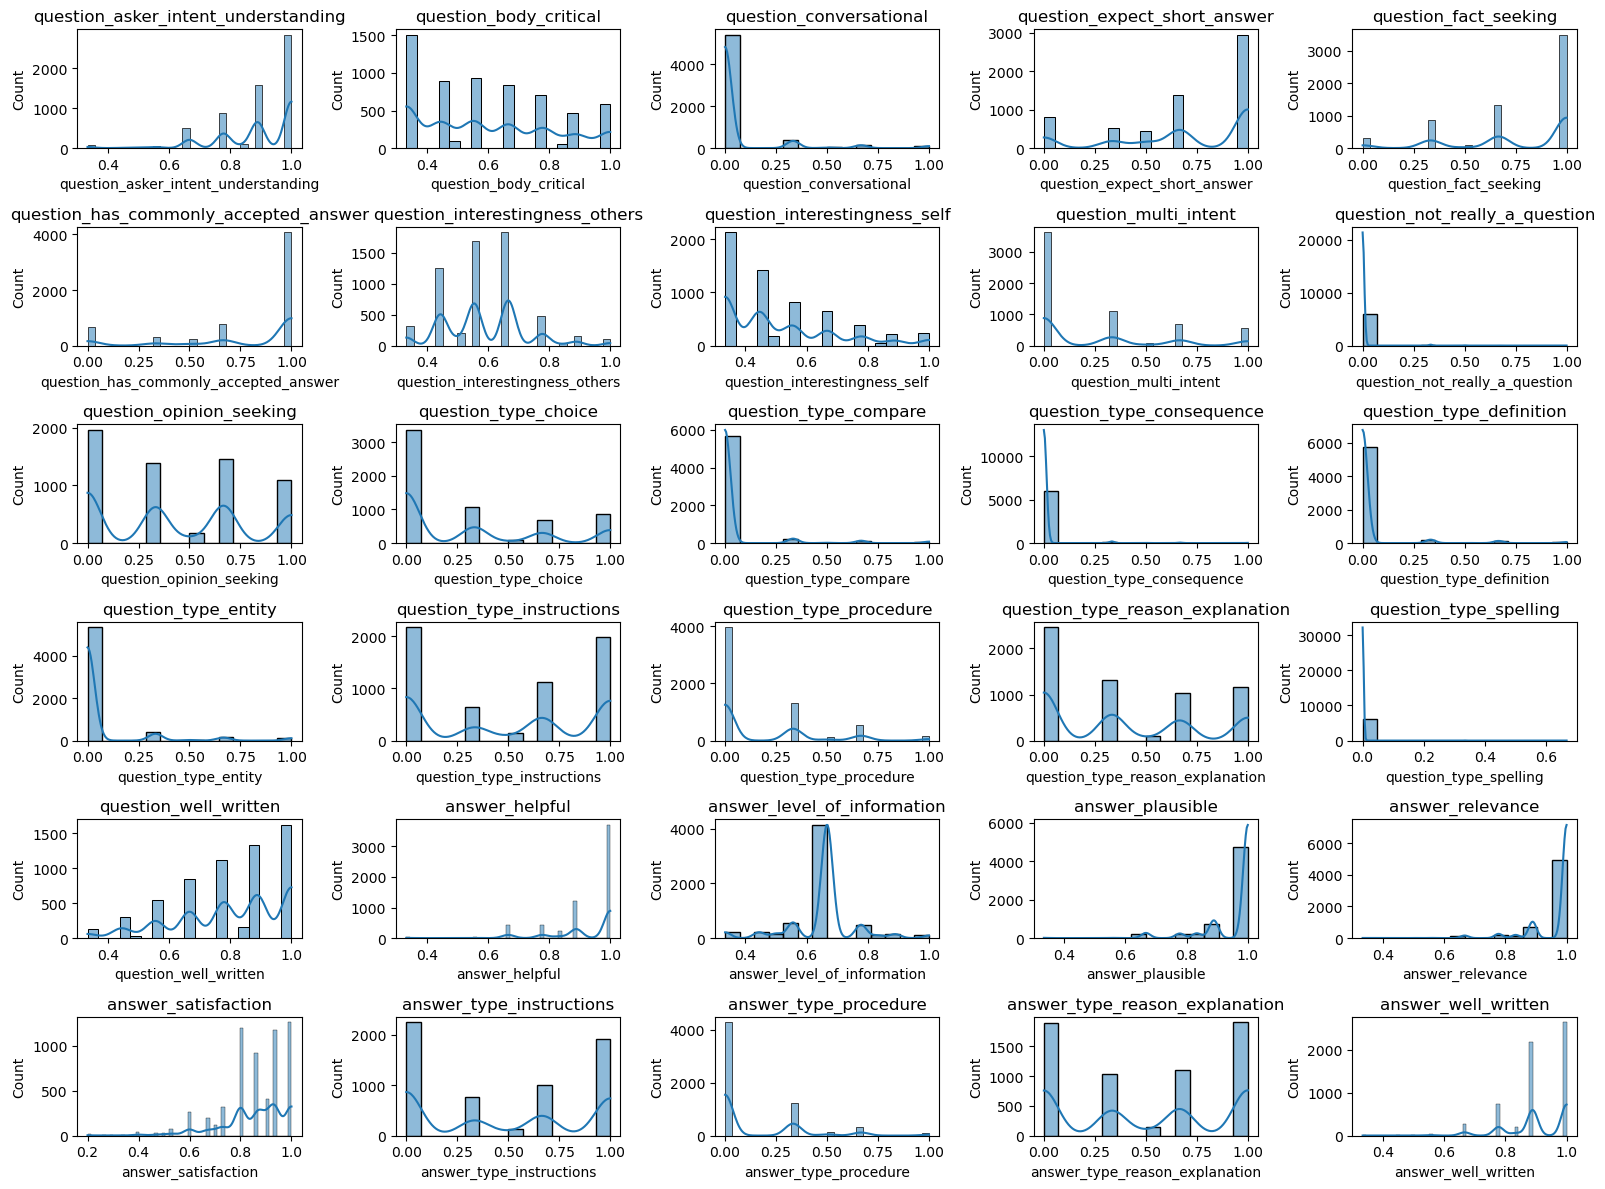

In [9]:
fig, axs = plt.subplots(6, 5, figsize=(16, 12))
axs = axs.ravel()

for i, col in enumerate(target_cols):
    sns.histplot(data=train, x=col, kde=True, ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()


Text data are around `800` length. Some of them are empty but title indicates the question in this case.

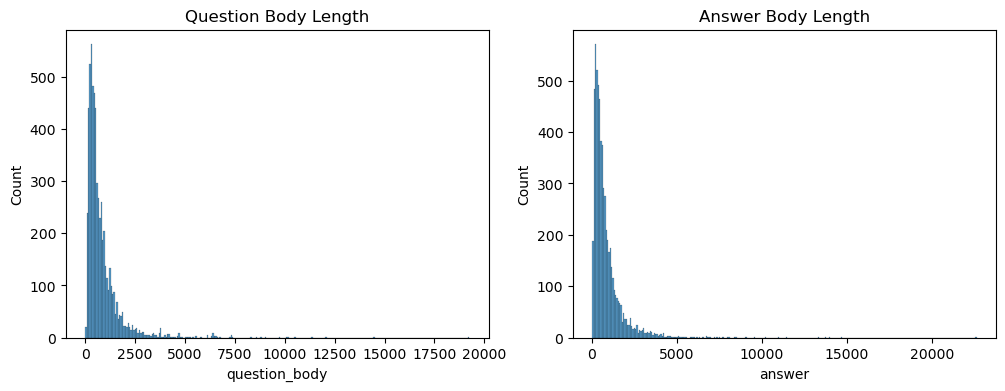

Question Body Length Stats: min = 1, mean = 833.7604869221911, max = 19253, std = 1029.0469863471067
Answer Body Length Stats: min = 21, mean = 839.3967757854911, max = 22636, std = 1017.3889229925646


In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
lens_quest = train.question_body.str.len()
sns.histplot(lens_quest, ax=axs[0])
axs[0].set_title("Question Body Length")
lens_ans = train.answer.str.len()
sns.histplot(lens_ans, ax=axs[1])
axs[1].set_title("Answer Body Length")
plt.show()

print("Question Body Length Stats: min = {}, mean = {}, max = {}, std = {}".format(
    lens_quest.min(), lens_quest.mean(), lens_quest.max(), lens_quest.std()))
print("Answer Body Length Stats: min = {}, mean = {}, max = {}, std = {}".format(
    lens_ans.min(), lens_ans.mean(), lens_ans.max(), lens_ans.std()))

In [11]:
train[train.question_title.str.len() < 10]

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written


In [12]:
train[train.question_body.str.len() < 10]

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
1297,2044,Removing blanks from a column in Excel,\n,Mike,https://superuser.com/users/79906,Could you sort the data in its existing locati...,Diem,https://superuser.com/users/66246,http://superuser.com/questions/271627,TECHNOLOGY,...,0.666667,1.000000,0.666667,1.0,1.0,0.6,1.0,0.0,0.0,0.666667
2748,4380,Removing blanks from a column in Excel,\n,Mike,https://superuser.com/users/79906,"If you select the column and press F5, click S...",Ian Wood,https://superuser.com/users/92720,http://superuser.com/questions/271627,TECHNOLOGY,...,0.666667,0.833333,0.666667,1.0,1.0,1.0,1.0,0.0,0.0,1.000000


In [13]:
train[train.answer.str.len() < 30].answer

3924    Not to my knowledge \n
Name: answer, dtype: object

The category class ditrubtion are as follows. Technology and Stackoverflow occupied `61%`. This is because dataset is mostly from stackoverflow.

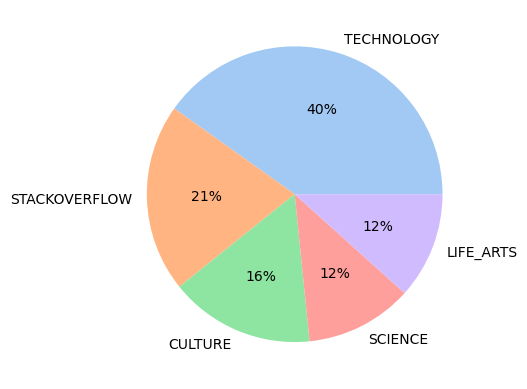

In [14]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(train.category.value_counts(), labels=train.category.value_counts().index, colors=colors, autopct='%.0f%%')
plt.show()

In [15]:
train['host_type'] = train.host.apply(lambda x: x.split('.')[0])
test['host_type'] = test.host.apply(lambda x: x.split('.')[0])
print("Top Genre: ")
print(train.host_type.value_counts()[:5])
print("Lower Genre: ")
print(train.host_type.value_counts()[-5:])

Top Genre: 
stackoverflow    1253
english           229
superuser         227
electronics       221
serverfault       213
Name: host_type, dtype: int64
Lower Genre: 
dsp             29
anime           21
cs               9
softwarerecs     8
robotics         2
Name: host_type, dtype: int64


## Feature engineering

we use OrdinalEncoder to convert the continuous target variables into discrete variables with ordered numeric values based on the EDA results

However, this transformations have following disadvantages.
* Can result in a loss of information since continuous values are being discretized, and the granularity of the original values is reduced
* Assumes that the ordinal relationship between the categories is consistent across all target variables, which may not be true in this dataset.

In [17]:
train[target_cols] = o_en.fit_transform(train[target_cols])

## Model building and evaluation

### Prepare validation dataset

We make training/valication set by splitting traing data into 60% and 40% respectively. While training and evaluating model, we don't use test data for data leakage prevention. The training data are `3647` entries, while the validation set are `2432`.

In [18]:
# For train
train["question"] = train["question_body"]  + " xxusr " + train["question_user_name"]
train["answer"] = train["answer"] + " xxusr " + train["answer_user_name"]
# For test
test["question"] = test["question_body"]  + " xxusr " + test["question_user_name"]
test["answer"] = test["answer"] + " xxusr " + test["answer_user_name"]

# Update feat columns
feat_cols = ["category", "question_title", "question", "answer"]
# Make sample for cross-validation test
X_train, X_test, y_train, y_test = train_test_split(train[feat_cols], train[target_cols], test_size=0.4, random_state=42)
X_train.shape, X_test.shape

((3647, 4), (2432, 4))

### Make baseline model

The first baseline model is supervised model, `LogisticRegression` on tfid vectorized text data. The `category` are onehot encoded, while other text data are tfidvectorized. The evaluation metric is `spearman coefficients`.

In [19]:
tfidvect = TfidfVectorizer(tokenizer=tokenize, min_df=10, max_df=0.5)
cv_results = cross_validate(get_model(tfidvect), X_train, y_train, cv=2, scoring=scorer, return_train_score=True)
print("Train score:", cv_results['train_score'].mean())
print("Val score:", cv_results['test_score'].mean())

Train score: 0.6883401067687964
Val score: 0.23259649215303468


### Select dimensionally reduction

The second model train on dimension reduced text data, using unsupervised model as feature reduction. We compare 2 technique, `NMF` and `TruncatedSVD` for feature reduction on our dataset. We concluded to use `TrunctedSVD` due to its better performance on validation set.

The `TruncatedSVD` are matrix factorization technique, the following images shows what it does. The technique decomposes a matrix into two smaller matrices where the singular values of the original matrix are preserved for the most part

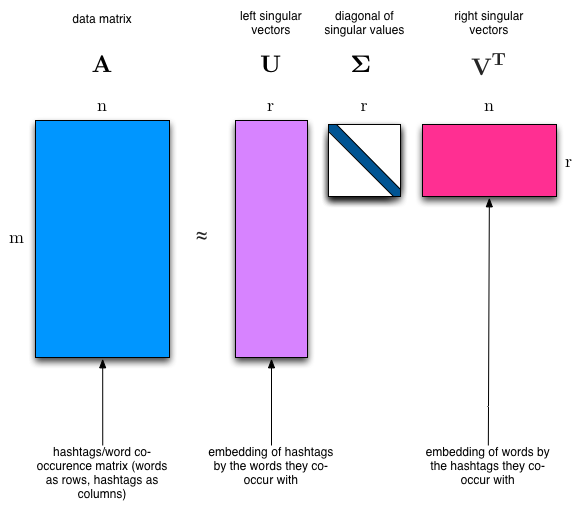

(source: [Facebook Research: Fast Randomized SVD](https://research.facebook.com/blog/2014/9/fast-randomized-svd/))

We just select most informative top rank features for training the model.

In [20]:
vect_with_tsvd = make_pipeline(tfidvect, TruncatedSVD(100))
vect_with_nmf = make_pipeline(tfidvect, NMF(100, init="nndsvd", max_iter=1000))

cv_results = cross_validate(get_model(vect_with_tsvd), X_train, y_train, cv=2, scoring=scorer, return_train_score=True)
print("TSVD result")
print("Train score:", cv_results['train_score'].mean())
print("Val score:", cv_results['test_score'].mean())

cv_results = cross_validate(get_model(vect_with_nmf), X_train, y_train, cv=2, scoring=scorer, return_train_score=True)
print("\nNMF result")
print("Train score:", cv_results['train_score'].mean())
print("Val score:", cv_results['test_score'].mean())

TSVD result
Train score: 0.37877142458406565
Val score: 0.22703753689693956

NMF result
Train score: 0.2341134082804422
Val score: 0.20877898790329713


### Compare supervised model

So far, we utilize `LogisticRegression` model but what about others? We compare other models and see its performance on validation set. he best performing model in terms of validation score is RandomForestClassifier with a validation score of 0.2487. The other models did not perform as well on the validation set, with scores ranging from 0.1638 to 0.2244. However, it's important to note that these are just initial results and we will want to fine-tune the hyperparameters of each model to see if we can improve their performance. After hyperparam tuning, we got the same result, `RandomForestClassifier` would fit better among others.

In [21]:
models = [LogisticRegression(max_iter=1000), 
          RidgeClassifier(max_iter=1000),
          RandomForestClassifier(n_estimators=100, min_samples_leaf=200),
          KNeighborsClassifier(n_neighbors=30),
          SVC()]

for model in models:
    cv_results = cross_validate(get_model(vect_with_tsvd, model), X_train, y_train, cv=2, scoring=scorer, return_train_score=True)
    print("\n", type(model).__name__)
    print("Train score:", cv_results['train_score'].mean())
    print("Val score:", cv_results['test_score'].mean())


 LogisticRegression
Train score: 0.3746594432006073
Val score: 0.22439113752622278

 RidgeClassifier
Train score: 0.39495739486360976
Val score: 0.21705747065095193

 RandomForestClassifier
Train score: 0.26414448837653753
Val score: 0.24878697944520262

 KNeighborsClassifier
Train score: 0.21898184347364333
Val score: 0.16381965408360588

 SVC
Train score: 0.37204223515540147
Val score: 0.21222970771971883


### Hyper parameter tuning

After selecting model with hyperparam tuning, `RandomForestClassifier` would be good to go. We apply hyper parameter tuning using randomized grid search. The same search applied to find better hyper parameter for `TfidVectorizer` and `TruncatedSVD` beforehand.

In [22]:
tfidvect = TfidfVectorizer(tokenizer=tokenize,
                           ngram_range=(1, 2),
                           max_df=0.5, 
                           min_df=3,
                           sublinear_tf=True)
tsvd = TruncatedSVD(100)
text_vect = make_pipeline(tfidvect, tsvd)

In [23]:
estimator = RandomForestClassifier(n_estimators=150)
model = get_model(text_vect, estimator)

param_distributions = {
    "model__estimator__min_samples_split": [2, 5, 10],
    "model__estimator__min_samples_leaf": [20, 40, 80],
    "model__estimator__max_features": ["auto", "sqrt", "log2"],
    "model__estimator__max_depth": [None, 5, 10, 20],
}

search = RandomizedSearchCV(
    model, param_distributions=param_distributions,
    cv=2, scoring=scorer, n_iter=10, n_jobs=-1, verbose=1, return_train_score=True,
)

search.fit(X_train, y_train)
print("train score: ", search.cv_results_['mean_train_score'][search.best_index_])
print("valid score: ", search.best_score_)
print("test score: ", spearmancoff(search.best_estimator_.predict(X_test), y_test))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
train score:  0.40687088857092957
valid score:  0.2612837822749815
test score:  0.27884287368395144


In [24]:
search.best_estimator_
estimator = RandomForestClassifier(max_depth=10,
                                   max_features='sqrt',
                                   min_samples_leaf=40,
                                   min_samples_split=5,
                                   n_estimators=150)

### Compare model performance with/without TruncatedSVD

We compare our model performance with/without unsupervised method. The model with TruncatedSVD results seems to fit better than model without. 

In [25]:
cv_results = cross_validate(get_model(text_vect, estimator), X_train, y_train, cv=2, scoring=scorer, return_train_score=True)
print("Model with TruncatedSVD")
print("Train score:", cv_results['train_score'].mean())
print("Val score:", cv_results['test_score'].mean())

cv_results = cross_validate(get_model(tfidvect, estimator), X_train, y_train, cv=2, scoring=scorer, return_train_score=True)
print("\nModel without TruncatedSVD")
print("Train score:", cv_results['train_score'].mean())
print("Val score:", cv_results['test_score'].mean())

Model with TruncatedSVD
Train score: 0.40585555689568453
Val score: 0.25071130284884546

Model without TruncatedSVD
Train score: 0.307640553239409
Val score: 0.24189600774773976


### Final submission

The following code makes submission file for competition. 

In [26]:
model = get_model(text_vect, estimator)
model.fit(train[feat_cols], train[target_cols])
y_pred = o_en.inverse_transform(model.predict(test[feat_cols]))

submission = pd.concat([pd.DataFrame({"qa_id": test["qa_id"]}), 
                        pd.DataFrame(y_pred, columns=target_cols)], 
                       axis=1)
submission.to_csv("submission.csv", index=False)
submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,8.0,0.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,...,8.0,8.0,4.0,8.0,8.0,12.0,0.0,0.0,4.0,8.0
1,46,8.0,0.0,0.0,4.0,4.0,4.0,3.0,0.0,0.0,...,8.0,8.0,4.0,8.0,8.0,15.0,4.0,0.0,0.0,8.0
2,70,8.0,5.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,...,8.0,8.0,4.0,8.0,8.0,16.0,0.0,0.0,4.0,8.0
3,132,8.0,0.0,0.0,4.0,4.0,4.0,3.0,0.0,0.0,...,8.0,8.0,4.0,8.0,8.0,16.0,4.0,0.0,0.0,7.0
4,200,8.0,0.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,...,8.0,8.0,4.0,8.0,8.0,16.0,0.0,0.0,4.0,8.0


## Discussion
### Result

The final submission score would be about 0.25 in terms of spearman metric.

### Pros/Cons for using TruncatedSVD

One interesting finding is feature reduction are preventing overfitting. It makes sense since it generalize the data if data is not noisy nor irrelevant. It can also reduce training and inference time due to its less dimentionality.

For pros
* Fast and simple when reduing dimensionality
* Prevent overfitting
* Reduce training and inference time

For cons
* Work poorly on non-linear relationship features

### Limitation of our approach

There are some limitations in our approach.

* The same hyperparameters may not be suitable for all text transformations, such as title and answer texts, and different hyperparameters may be needed for different vectorizations.
* Text conversion would make difficult to find relationship between feature and response directly. As a result, outlier would exist but we can't find it easily.
* More precise grid search, like finding better param to model and text vectorizer at the same time, would be better finding strategy
* Order encoder may dismiss some relationship between feature and target, but not its not obvious because vectorized data can't be interpretable.

## Summary

This notebook makes model to predict subjective labels for QA paris using dataset from kaggle. The dataset consists of questions and its answers, along with subjective labels and indicating the degree of agree/disagreements. The target are discrete so the proble is framed as classification task.

The text processing steps involve using the TfidfVectorizer to convert the text data into vectorized numerical data, and the TruncatedSVD algorithm to reduce the dimensionality of the resulting feature matrix. The random forest classifier is used for supervised learning, and the hyperparameters of the model are optimized using cross-validation and randomized grid search.

The final submission achieves a Spearman correlation of about 0.25. While this is not the highest score in the competition, it demonstrates the effectiveness of the approach in predicting subjective labels. 

## Regerence
* [This project's repo]https://github.com/Akitsuyoshi/unsupervised_ml_app
* https://www.kaggle.com/competitions/google-quest-challenge/data
* https://www.python-graph-gallery.com/25-histogram-with-several-variables-seaborn
* https://machinelearningmastery.com/multi-output-regression-models-with-python/
* https://towardsdatascience.com/columntransformer-meets-natural-language-processing-da1f116dd69f
* https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data
* https://www.kaggle.com/code/jhoward/nb-svm-strong-linear-baseline
* https://www.kaggle.com/code/codename007/start-from-here-quest-complete-eda-fe
* https://github.com/fastai/course-nlp/blob/master/2-svd-nmf-topic-modeling.ipynb